# Blood Pressure Analysis and Prediction
## Josh McComack
## Overview
In this Jupyter Notebook I investigate the feasibility of predicting systolic and diastolic blood pressure based on the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey/home) (NHANES) data set from 2013-2014 found on kaggle.com. The primary questions I wish to answer are:
1. Which variables from the survey are most predictive empirically and do they correspond to the what mainstream literature identifies as key factors in blood pressure levels?
2. Comparing scikit-learn’s SGDRegressor, MultiTaskLasso, and RandomForestRegressor, which regression model offers the best predictions on this data set?
3. Does the best model perform well enough to serve as a possible supplementary or alternative way of “measuring” blood pressure?

## Import Libraries and Data
First we will import our libraries and data. The NHANES data is stored in 6 seperate csv files.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import MultiTaskLasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load Data
path = "./national-health-and-nutrition-examination-survey/"
demographic_df = pd.read_csv(path + "demographic.csv")
diet_df = pd.read_csv(path + "diet.csv")
exam_df = pd.read_csv(path + "examination.csv")
labs_df = pd.read_csv(path + "labs.csv")
# There seems to be a non UTF-8 Character in the medications data set.
meds_df = pd.read_csv(path + "medications.csv", encoding = "latin1")
questionnaire_df = pd.read_csv(path + "questionnaire.csv")

In [3]:
# Join all data frames into a single data frame
combined_df = demographic_df
for frame in [diet_df, exam_df, labs_df, meds_df, questionnaire_df]:
    combined_df = combined_df.merge(frame, left_on="SEQN", right_on="SEQN", how="outer")
combined_df.head(10)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
2,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
3,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
4,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
5,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
6,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
7,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
8,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
9,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN


## Data Selection
Our data set contains a total 1824 different columns, with overview of the columns found [here](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey/home). To get started however, we will focus on features which have been identified as possible factors in blood presssure levels:
* Age [1][2]
* Gender [2]
* Sodium intake [1]
* Smoking [1][2]
* Exercise levels [1][2]
* Alcohol intake [1][2]
* Diabetes [2]
* Weight or Obesity [1][2]

* Family history of high blood pressure [1][2]
* Genetics (Which probably ties in with gender, and family history) [1]
* Stress levels [1][2]
* Chronic kidney Disease [1][2]


References:
* [1] [www.webmd.com](https://www.webmd.com/hypertension-high-blood-pressure/guide/blood-pressure-causes#1)
* [2] [www.heart.org](http://www.heart.org/en/health-topics/high-blood-pressure/why-high-blood-pressure-is-a-silent-killer/know-your-risk-factors-for-high-blood-pressure)


In [4]:
# We will create a list to store all of our selected columns for convenience. 
selected_columns = [];

From the demographic data set, we can use the survey participants' age and gender identified in columns DMDHRAGE and RIAGENDR defined in the detailed column description found [here](https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Demographics&CycleBeginYear=2013).

In [5]:
demographic_columns = ['DMDHRAGE', 'RIAGENDR']
selected_columns += demographic_columns
demographic_df[demographic_columns].head()

,DMDHRAGE,RIAGENDR
0,69,1
1,54,1
2,72,1
3,33,1
4,78,2


The dietary data set contains potentially usefull information about sodium intake and diet, however the detailed column description does not explain how this information is encoded. So we will use the more quantifiable sodium column LBXSNASI taken from the [laboratory data set](https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Laboratory&CycleBeginYear=2013). 

Note: there seems to be many more sodium columns missing this data set.

In [6]:
labs_columns = ['LBXSNASI']
selected_columns += labs_columns
labs_df[labs_columns].head()

,LBXSNASI
0,136.0
1,128.0
2,142.0
3,NaN
4,142.0


The [questionnaire](https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2013) contains lots of varius data about smoking, exercise, and alcohol habits. A few columns we will use are:
##### Smoking

* SMQ040: Do you now smoke cigarettes?
* SMQ020: Have you smoked at least 100 cigarettes in your entire life?
* SMD650: During the past 30 days, on the days that you smoked, about how many cigarettes did you smoke per day?
* SMD641: On how many of the past 30 days did you smoke a cigarette?

##### Exercise

* PAQ677: On how many of the past 7 days did you exercise or participate in physical activity for at least 20 minutes that made you sweat and breathe hard, such as basketball, soccer, running, swimming laps, fast bicycling, fast dancing, or similar activities?
* PAQ678: On how many of the past 7 days did you do exercises to strengthen or tone your muscles, such as push-ups, sit-ups, or weight lifting?

##### Alcohol

* ALQ101: In any one year, have you had at least 12 drinks of any type of alcoholic beverage? By a drink, I mean a 12 oz. beer, a 5 oz. glass of wine, or one and half ounces of liquor.
* ALQ130: In the past 12 months, on those days that you drank alcoholic beverages, on the average, how many drinks did you have?

##### Diabetes
* DIQ010: Other than during pregnancy, have you ever been told by a doctor or health professional that you have diabetes or sugar diabetes?

In [7]:
questionnaire_columns = ['SMQ040', 'SMQ020', 'SMD650', 'SMD641', 'PAQ677', 'PAQ678', 'ALQ101', 'ALQ130', 'DIQ010']
selected_columns += questionnaire_columns
questionnaire_df[questionnaire_columns].head()

,SMQ040,SMQ020,SMD650,SMD641,PAQ677,PAQ678,ALQ101,ALQ130,DIQ010
0,3.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0
1,2.0,1.0,1.0,1.0,NaN,NaN,1.0,4.0,1.0
2,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,2.0


Examining the medications data set, we can see who is taking medication for blood pressure and/or diabetes. 


In [8]:
meds_columns = ['RXDDRUG', 'RXDRSD1']
selected_columns += meds_columns
meds_df[meds_columns].head(11)

,RXDDRUG,RXDRSD1
0,99999,NaN
1,INSULIN,Type 2 diabetes mellitus
2,GABAPENTIN,Restless legs syndrome
3,INSULIN GLARGINE,Type 2 diabetes mellitus
4,OLMESARTAN,Type 2 diabetes mellitus with kidney complicat...
5,SIMVASTATIN,Pure hypercholesterolemia
6,INSULIN ASPART,Type 2 diabetes mellitus
7,INSULIN GLARGINE,Type 2 diabetes mellitus
8,PANCRELIPASE,"Disease of pancreas, unspecified"
9,SIMVASTATIN,Pure hypercholesterolemia


The data set doesn't seem to contain direct information on stress levels, chronic kidney disease, or family history of high blood pressure. But from the examination data set we can collect information on body mass index and blood pressure readings:

#####  Body Mass Index

* BMXBMI: Body Mass Index (kg/m**2)	

#####  Blood Pressure Readings
* BPXDI 1-4: Diastolic blood pressure mm Hg (first through fourth readings)
* BPXSY 1-4: Systolic blood pressure mm Hg (first through fourth readings)

In [9]:
exam_columns = ['BMXBMI', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXDI4', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']
selected_columns += exam_columns
exam_df[exam_columns].head()

,BMXBMI,BPXDI1,BPXDI2,BPXDI3,BPXDI4,BPXSY1,BPXSY2,BPXSY3,BPXSY4
0,26.7,72.0,76.0,74.0,NaN,122.0,114.0,102.0,NaN
1,28.6,62.0,80.0,42.0,NaN,156.0,160.0,156.0,NaN
2,28.9,90.0,76.0,80.0,NaN,140.0,140.0,146.0,NaN
3,17.1,38.0,34.0,38.0,NaN,108.0,102.0,104.0,NaN
4,19.7,86.0,88.0,86.0,NaN,136.0,134.0,142.0,NaN


## Data Cleaning
Now that we've identified the columns we wish to use, lets drop them into a single data frame.

In [10]:
selected_df = combined_df[selected_columns]
selected_df.head()

,DMDHRAGE,RIAGENDR,LBXSNASI,SMQ040,SMQ020,SMD650,SMD641,PAQ677,PAQ678,ALQ101,...,RXDRSD1,BMXBMI,BPXDI1,BPXDI2,BPXDI3,BPXDI4,BPXSY1,BPXSY2,BPXSY3,BPXSY4
0,69,1,136.0,3.0,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,26.7,72.0,76.0,74.0,NaN,122.0,114.0,102.0,NaN
1,69,1,136.0,3.0,1.0,NaN,NaN,NaN,NaN,1.0,...,Type 2 diabetes mellitus,26.7,72.0,76.0,74.0,NaN,122.0,114.0,102.0,NaN
2,54,1,128.0,2.0,1.0,1.0,1.0,NaN,NaN,1.0,...,Restless legs syndrome,28.6,62.0,80.0,42.0,NaN,156.0,160.0,156.0,NaN
3,54,1,128.0,2.0,1.0,1.0,1.0,NaN,NaN,1.0,...,Type 2 diabetes mellitus,28.6,62.0,80.0,42.0,NaN,156.0,160.0,156.0,NaN
4,54,1,128.0,2.0,1.0,1.0,1.0,NaN,NaN,1.0,...,Type 2 diabetes mellitus with kidney complicat...,28.6,62.0,80.0,42.0,NaN,156.0,160.0,156.0,NaN


We'll define a couple helper methods for evaluating the contents of each column

In [11]:
def print_uniques(df):
    """Prints each unique value for each column in the data frame 
       with a null count.
       
    Args:
        df: Pandas DataFrame to print unique values from.
        
    """
    for column in df.columns:
        print('{} ({}):{}'.format(column, df[column].dtypes, set(df[column].astype('str'))))
        print_null_count(df[column])
        print()
        
def print_null_count(series):
    """Prints the number of null values in the given series.
    
    Args:
        series: Pandas Series to count null values from.
        
    """
    number_null = np.sum(series.isnull())
    size = len(series)
    percent_null = 0 if size <= 0 else (number_null / size)
    print("{} null count: {} ({:.1f}%)".format(series.name, number_null, percent_null))

#####  Demographic Data

In [12]:
print_uniques(selected_df[demographic_columns])

DMDHRAGE (int64):{'49', '24', '37', '53', '28', '20', '48', '67', '57', '66', '41', '47', '56', '44', '54', '35', '19', '65', '33', '80', '21', '72', '32', '52', '77', '71', '51', '30', '76', '70', '79', '55', '18', '61', '34', '31', '68', '73', '38', '59', '43', '78', '58', '25', '39', '74', '50', '46', '69', '45', '27', '75', '36', '40', '22', '26', '64', '63', '42', '62', '29', '60', '23'}
DMDHRAGE null count: 0 (0.0%)

RIAGENDR (int64):{'2', '1'}
RIAGENDR null count: 0 (0.0%)



Thankfully neither column is missing any values. We will let the age column remain an int, but convert the gender column to a category with human readable definitions rather than "1" or "2". Definition can be found [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm) in the data set description.

In [13]:
selected_df['RIAGENDR'] = selected_df['RIAGENDR'].map({1:'male', 2:'female'})
selected_df['RIAGENDR'] = selected_df['RIAGENDR'].astype('category')

#####  Laboratory Data

In [14]:
print_uniques(selected_df[labs_columns])

LBXSNASI (float64):{'151.0', '137.0', '131.0', '154.0', '141.0', '146.0', '147.0', '140.0', '130.0', '134.0', '127.0', '133.0', '138.0', '135.0', '145.0', '143.0', '144.0', '142.0', '132.0', '148.0', '136.0', '150.0', '124.0', 'nan', '129.0', '139.0', '128.0', '119.0'}
LBXSNASI null count: 4677 (0.2%)



Since we have very few missing values, and everyone consumes some amount of sodium, it will probably be a safe bet to fill the missing values with the average from data set. Also, since all the values are really integer values, we will convert the data type.

In [15]:
selected_df['LBXSNASI'].fillna(selected_df['LBXSNASI'].mean(), inplace=True)
selected_df['LBXSNASI'] = selected_df['LBXSNASI'].astype('int')
print_uniques(selected_df[labs_columns])

LBXSNASI (int32):{'130', '139', '119', '136', '129', '124', '128', '132', '145', '151', '147', '127', '131', '138', '148', '133', '144', '142', '140', '137', '141', '134', '135', '143', '154', '146', '150'}
LBXSNASI null count: 0 (0.0%)



#####  Questionnaire Data

In [16]:
print_uniques(selected_df[questionnaire_columns])

SMQ040 (float64):{'1.0', '3.0', '2.0', 'nan'}
SMQ040 null count: 12518 (0.6%)

SMQ020 (float64):{'9.0', '1.0', 'nan', '2.0'}
SMQ020 null count: 4586 (0.2%)

SMD650 (float64):{'20.0', '8.0', '11.0', '15.0', '1.0', '3.0', '2.0', '40.0', '16.0', '10.0', '50.0', '28.0', '6.0', '999.0', '90.0', '29.0', '13.0', '9.0', '5.0', '4.0', '30.0', '25.0', '27.0', '60.0', 'nan', '12.0', '14.0', '17.0', '7.0', '18.0'}
SMD650 null count: 17052 (0.8%)

SMD641 (float64):{'20.0', '22.0', '26.0', '8.0', '21.0', '23.0', '15.0', '1.0', '3.0', '2.0', '16.0', '10.0', '28.0', '6.0', '29.0', '19.0', '27.0', '5.0', '4.0', '30.0', '0.0', '25.0', 'nan', '12.0', '24.0', '14.0', '17.0', '7.0', '18.0'}
SMD641 null count: 16964 (0.8%)

PAQ677 (float64):{'0.0', 'nan', '1.0', '3.0', '2.0', '99.0', '7.0', '6.0', '5.0', '4.0'}
PAQ677 null count: 19395 (1.0%)

PAQ678 (float64):{'0.0', 'nan', '1.0', '3.0', '2.0', '7.0', '6.0', '5.0', '4.0'}
PAQ678 null count: 19395 (1.0%)

ALQ101 (float64):{'9.0', '1.0', 'nan', '2.0'}
ALQ101

The smoking field definitions can be found [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/SMQ_H.htm#SMQ040). We will categorize these fields with their associated responses. For the missing values, we will recategorize as "2: Some days" if they smoked at all during the last 30 days. If not, we will categorize as "Not smoking".

In [17]:
selected_df['SMQ040'] = selected_df.apply(
    lambda x:
    # Find if they smoked 1 or more cigarettes in the past 30 days
    2 if np.isnan(x['SMQ040']) and x['SMD650'] >= 1 and x['SMD650'] < 200
    # Find if they smoked 1 or more days in the past 30 days
    else 2 if np.isnan(x['SMQ040']) and x['SMD641'] >= 1 and x['SMD641'] <= 30
    # Classify them as not currently smoking if there is no data from 
    # the last 30 days
    else 3 if np.isnan(x['SMQ040'])
    # Otherwise use the original value
    else x['SMQ040'], axis=1)

In [18]:
# Convert to a category with readable definitions
selected_df['SMQ040'] = selected_df['SMQ040'].astype('int')
selected_df['SMQ040'] = selected_df['SMQ040'].map({1:'smokes every day', 
                                                   2:'smokes some days',
                                                   3:'does not smoke'})
selected_df['SMQ040'] = selected_df['SMQ040'].astype('category')
print_uniques(selected_df[['SMQ040']])

SMQ040 (category):{'smokes every day', 'does not smoke', 'smokes some days'}
SMQ040 null count: 0 (0.0%)



In [19]:
# For "Smoked at least 100 cigarettes in life" (SMQ020) we will fill missing
# values with with the "Don't know" classification and change the data 
# type to category.
selected_df['SMQ020'].fillna(9, inplace=True)
selected_df['SMQ020'] = selected_df['SMQ020'].astype('int')
selected_df['SMQ020'] = selected_df['SMQ020'].map({1: 'yes', 2:'no', 9:'unknown'})
selected_df['SMQ020'] = selected_df['SMQ020'].astype('category')


In [20]:
# For Avg number cigarettes/day during past 30 days (SMD650) we will fill
# missing values with 0 if they don't smoke, and with "Don't know" 
# if they do smoke.
selected_df['SMD650'] = selected_df.apply(
    lambda x:
    0 if np.isnan(x['SMD650']) and x['SMQ040'] == 3
    else 999 if np.isnan(x['SMD650'])
    else x['SMD650'], axis=1)

In [21]:
# Convert to category and classify categories.
# 1 to 90 Range of Values for cigarettes smoked
# 95: 95 cigarettes or more
# 999: Unknown how many smoked
selected_df['SMD650'] = selected_df['SMD650'].astype('int').astype('category')
selected_df['SMD650'] = selected_df['SMD650'].apply(lambda x: 
                                                    'unknown' if x == 999 
                                                    else x)

In [22]:
# Number of days smoked cigs during past 30 days (SMD641).
# We will fill missing values with 0 if they do not smoke,
# else with 'unknown' if they do smoke but the value is missing.
selected_df['SMD641'] = selected_df.apply(
    lambda x:
    0 if np.isnan(x['SMD641']) and x['SMQ040'] == 3
    else 99 if np.isnan(x['SMD641'])
    else x['SMD641'], axis=1)

In [23]:
# Convert to category.
selected_df['SMD641'] = selected_df['SMD641'].astype('int').astype('category')
selected_df['SMD641'] = selected_df['SMD641'].apply(lambda x: 
                                                    'unknown' if x == 99 
                                                    else x)

In [24]:
# PAQ677 and PAQ678 deal with exercise over the past 7 days.
# we will replace any null values with 'unknown'.
selected_df['PAQ677'].fillna(99, inplace=True)
selected_df['PAQ678'].fillna(99, inplace=True)
selected_df['PAQ677'] = selected_df['PAQ677'].astype('int').astype('category')
selected_df['PAQ678'] = selected_df['PAQ678'].astype('int').astype('category')
selected_df['PAQ677'] = selected_df['PAQ677'].apply(lambda x: 
                                                    'unknown' if x == 99 
                                                    else x)
selected_df['PAQ678'] = selected_df['PAQ678'].apply(lambda x: 
                                                    'unknown' if x == 99 
                                                    else x)

In [25]:
# ALQ101 considers if the patient had at least 12 alcohol drinks/1 yr.
# Missing values we will categorize as unknown.
selected_df['ALQ101'].fillna(9, inplace=True)
selected_df['ALQ101'] = selected_df['ALQ101'].astype('int')
selected_df['ALQ101'] = selected_df['ALQ101'].map({1:'yes', 2:'no', 9:'unknown'})
selected_df['ALQ101'] = selected_df['ALQ101'].astype('category')


In [26]:
# ALQ130 deals with average number of alcoholic drinks/day in the past 12 months
# It's categories contain a range of values and an "unknown" category.
# missing values we will categorize as "unknown"
selected_df['ALQ130'].fillna(9, inplace=True)
selected_df['ALQ130'] = selected_df['ALQ130'].astype('int').astype('category')
selected_df['ALQ130'] = selected_df['ALQ130'].apply(lambda x: 
                                                    'unknown' if x == 999 
                                                    else x)

In [27]:
# DIQ010 determines whether a doctor has told the patient that they have 
# diabetes or not. We will classify missing values as "unknown".
selected_df['DIQ010'].fillna(9, inplace=True)
selected_df['DIQ010'] = selected_df['DIQ010'].astype('int')
selected_df['DIQ010'] = selected_df['DIQ010'].map({1:'yes', 
                                                   2:'no',
                                                   3:'borderline',
                                                   7:'refused to answer',
                                                   9:'unknown'})
selected_df['DIQ010'] = selected_df['DIQ010'].astype('category')



In [28]:
# Let's take a look at the final results for the questionnaire data set
print_uniques(selected_df[questionnaire_columns])

SMQ040 (category):{'smokes every day', 'does not smoke', 'smokes some days'}
SMQ040 null count: 0 (0.0%)

SMQ020 (category):{'no', 'yes', 'unknown'}
SMQ020 null count: 0 (0.0%)

SMD650 (category):{'20', '28', '5', '8', '1', '3', '12', '14', '13', '10', '2', '6', '7', '30', '11', '18', '16', '9', '17', '25', '90', '50', '15', '27', '40', 'unknown', '29', '4', '60'}
SMD650 null count: 0 (0.0%)

SMD641 (category):{'24', '20', '28', '5', '8', '0', '19', '1', '3', '12', '14', '21', '10', '2', '6', '7', '30', '18', '16', '17', '25', '15', '27', '22', 'unknown', '26', '29', '4', '23'}
SMD641 null count: 0 (0.0%)

PAQ677 (category):{'1', '3', '5', 'unknown', '2', '4', '6', '7', '0'}
PAQ677 null count: 0 (0.0%)

PAQ678 (category):{'1', '3', '5', 'unknown', '2', '4', '6', '7', '0'}
PAQ678 null count: 0 (0.0%)

ALQ101 (category):{'no', 'yes', 'unknown'}
ALQ101 null count: 0 (0.0%)

ALQ130 (category):{'24', '20', '5', '8', '1', '3', '12', '14', '13', '2', '10', '6', '7', '11', '18', '16', '9', '25

#####  Medication data
The medication columns contain a wide variety of values, since we are only concerned with blood pressure and diabetes for now, we will columns to track
only those patients which are on medication for these issues.

In [29]:
print_null_count(selected_df['RXDRSD1'])

RXDRSD1 null count: 6561 (0.3%)


In [30]:
selected_df['RXDRSD1'] = selected_df['RXDRSD1'].astype('str')
selected_df['type1_diabets'] = selected_df.apply(
    lambda x: 
    'yes' if 'Type 1 diabetes' in x['RXDRSD1'] else 'no', axis=1)
selected_df['type2_diabets'] = selected_df.apply(
    lambda x: 
    'yes' if 'Type 2 diabetes' in x['RXDRSD1'] else 'no', axis=1)
selected_df['on_bp_meds'] = selected_df.apply(
    lambda x: 
    'yes' if 'hypertension' in x['RXDRSD1'] else 'no', axis=1)
for column in ['type1_diabets', 'type2_diabets', 'on_bp_meds']:
    selected_df[column] = selected_df[column].astype('category')

In [31]:
#####  Exam data

In [32]:
print_uniques(selected_df[exam_columns])

BMXBMI (float64):{'39.7', '43.5', '35.8', '14.9', '25.4', '42.1', '42.3', '56.9', '15.0', '44.2', '53.0', '16.1', '26.2', '32.1', '32.6', '31.9', '33.4', '41.1', '32.0', '42.0', '46.3', '44.9', '55.3', '25.0', '35.4', '27.3', '17.2', '24.3', '18.1', '49.5', '31.7', '37.1', '12.7', '48.1', '26.6', '19.4', '41.0', '30.9', '56.7', '32.7', '21.7', '40.5', '13.4', '31.4', '14.0', '51.2', '28.9', '21.9', '33.5', '51.3', '13.2', '17.6', '26.0', '31.6', '56.3', '27.2', '15.2', '13.7', '51.0', '26.1', '30.2', '21.8', '23.2', '36.0', '40.8', '51.4', '34.1', '30.6', '22.7', '17.9', '33.7', '28.5', '18.3', '34.3', '39.1', '38.0', '45.9', '15.3', '18.4', '43.4', '44.5', '32.5', '20.1', '13.8', '22.2', '29.6', '23.6', '25.9', '16.3', '49.6', '36.5', '52.0', '24.5', '37.7', '34.5', '48.8', '56.4', '18.5', '48.5', '27.8', '15.1', '18.2', '14.6', '19.9', '46.7', '26.3', '17.5', '31.3', '51.9', '52.7', 'nan', '18.6', '18.9', '37.0', '17.3', '31.5', '30.8', '54.2', '48.3', '37.4', '42.9', '34.4', '46.9',

In [33]:
# It makese sense for body mass index to remain a float, we will fill any
# missing values with just the mean.
selected_df['BMXBMI'].fillna(selected_df['BMXBMI'].mean(), inplace=True)


In [34]:
# Since Systolic and Diastolic blood pressure is recorded as ints, we will 
# convert their types and replace the missing values with averages since there
# are only a few. 
for column in exam_columns[1:]:
    selected_df[column].fillna(selected_df[column].mean(), inplace=True)
    selected_df[column] = selected_df[column].astype('int')

In [35]:
# Since we are trying to predict blood pressure, let's create a target column
# with the median from each of the 4 blood pressure readings to ignore outliers.
selected_df['diastolic'] = selected_df.apply(
    lambda x: 
    int(np.median([x['BPXDI1'], x['BPXDI2'], x['BPXDI3'], x['BPXDI4']])),
    axis=1)

selected_df['systolic'] = selected_df.apply(
    lambda x: 
    int(np.median([x['BPXSY1'], x['BPXSY2'], x['BPXSY3'], x['BPXSY4']])), 
    axis=1)
selected_df[['diastolic', 'systolic']].describe()

,diastolic,systolic
count,20194.000000,20194.000000
mean,66.581410,123.784689
std,11.723732,16.430115
min,0.000000,66.000000
25%,63.000000,114.000000
50%,66.000000,123.000000
75%,72.000000,131.000000
max,114.000000,228.000000


In [36]:
# Since diastolic contains some impossibly low values, we will replace them with
# a min value.
selected_df['diastolic'] = selected_df['diastolic'].apply(
    lambda x: 20 if x < 20 else x)

In [37]:
print_uniques(selected_df[['diastolic', 'systolic']])

diastolic (int64):{'49', '67', '57', '41', '35', '80', '33', '109', '87', '71', '97', '51', '30', '68', '38', '106', '25', '105', '88', '22', '62', '84', '83', '24', '28', '102', '47', '113', '44', '54', '65', '21', '77', '52', '70', '101', '96', '73', '93', '78', '58', '86', '91', '50', '75', '40', '64', '81', '42', '82', '59', '20', '66', '56', '111', '89', '72', '98', '79', '55', '114', '103', '94', '34', '31', '92', '43', '39', '90', '45', '27', '26', '107', '23', '37', '53', '48', '108', '32', '104', '76', '61', '95', '74', '46', '69', '99', '36', '85', '100', '63', '29', '60', '110'}
diastolic null count: 0 (0.0%)

systolic (int64):{'130', '126', '115', '176', '136', '178', '109', '132', '152', '87', '97', '172', '127', '121', '138', '117', '140', '106', '105', '192', '88', '194', '196', '180', '84', '163', '83', '123', '191', '161', '102', '164', '139', '165', '171', '113', '119', '173', '182', '77', '101', '145', '201', '147', '96', '184', '118', '181', '93', '144', '91', '86',

In [38]:
selected_df.columns

Index(['DMDHRAGE', 'RIAGENDR', 'LBXSNASI', 'SMQ040', 'SMQ020', 'SMD650',
       'SMD641', 'PAQ677', 'PAQ678', 'ALQ101', 'ALQ130', 'DIQ010', 'RXDDRUG',
       'RXDRSD1', 'BMXBMI', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXDI4', 'BPXSY1',
       'BPXSY2', 'BPXSY3', 'BPXSY4', 'type1_diabets', 'type2_diabets',
       'on_bp_meds', 'diastolic', 'systolic'],
      dtype='object')

In [39]:
# Before we start analyzing the data, let's drop any columns we don't need, 
# and rename the columns to something a little more human readable. 
df = selected_df.drop(columns=exam_columns[1:] + meds_columns, axis=1)
df = df.rename(index=str, columns={
    'DMDHRAGE':'age', 
    'RIAGENDR':'gender',
    'LBXSNASI':'sodium',
    'SMQ040':'smoker', 
    'SMQ020':'atleast_100_smokes_over_lifetime',
    'SMD650':'smokes_per_day',
    'SMD641':'days_smoked_last_month', 
    'PAQ677':'cardio_past_week',
    'PAQ678':'strength_train_past_week', 
    'ALQ101':'atleast_12_drinks_per_year', 
    'ALQ130':'avg_drinks_per_day', 
    'DIQ010':'told_have_diabetes', 
    'BMXBMI':'bmi',
})
df.columns

Index(['age', 'gender', 'sodium', 'smoker', 'atleast_100_smokes_over_lifetime',
       'smokes_per_day', 'days_smoked_last_month', 'cardio_past_week',
       'strength_train_past_week', 'atleast_12_drinks_per_year',
       'avg_drinks_per_day', 'told_have_diabetes', 'bmi', 'type1_diabets',
       'type2_diabets', 'on_bp_meds', 'diastolic', 'systolic'],
      dtype='object')

## Data Analysis
Now we will create plots to visualize the data and see if we can find any correlations in the data with blood pressure levels.

In [40]:
df.describe()

,age,sodium,bmi,diastolic,systolic
count,20194.000000,20194.000000,20194.000000,20194.000000,20194.000000
mean,53.359958,139.586857,28.415333,66.711201,123.784689
std,16.906852,2.212592,8.208375,11.086027,16.430115
min,18.000000,119.000000,12.100000,20.000000,66.000000
25%,40.000000,139.000000,23.200000,63.000000,114.000000
50%,54.000000,139.000000,28.300000,66.000000,123.000000
75%,67.000000,141.000000,32.400000,72.000000,131.000000
max,80.000000,154.000000,82.900000,114.000000,228.000000


In [41]:
# Create some simple helper methods to print plots easily
def is_numerical(series):
    """Checks if a series is made up of numerical data or not.
    
    Args:
        series: Series object to be checked
        
    Returns:
        True if the data are integers or floats, False otherwise
    
    """
    return series.dtype == 'int64' or series.dtype == 'float64' \
        or series.dtype == 'int32' or series.dtype == 'float32'
    
    
def plot(columns, df):
    """Prints a seaborn plot for numerical and categorical data with blood pressure
    
    Args:
    columns: a list of column names
    df: a DataFrame object to plot from
    
    """
    height = len(columns) * 2
    index = 0
    fig, axes = plt.subplots(height, 1, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.5)
    for column in columns:
        if is_numerical(df[column]):
            sns.scatterplot(x=column, y='systolic', data=df, ax=axes[index])
            index += 1
            sns.scatterplot(x=column, y='diastolic', data=df, ax=axes[index])
            index += 1
        elif df[column].dtype.name == 'category':
            sns.boxplot(x=column, y='systolic', data=df, ax=axes[index])
            index += 1
            sns.boxplot(x=column, y='diastolic', data=df, ax=axes[index])
            index += 1


### Age and Gender

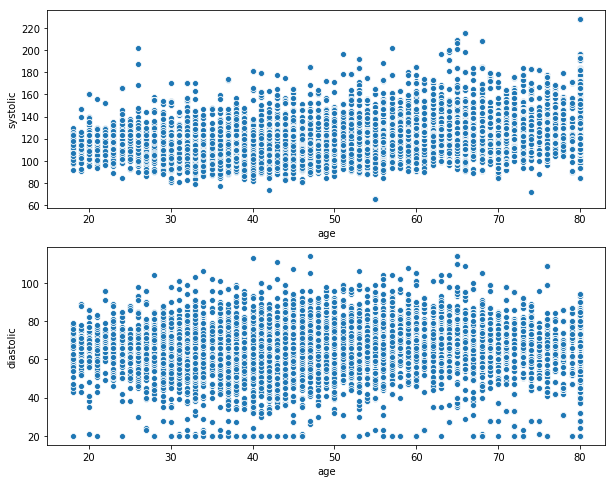

In [42]:
plot(['age'], df)

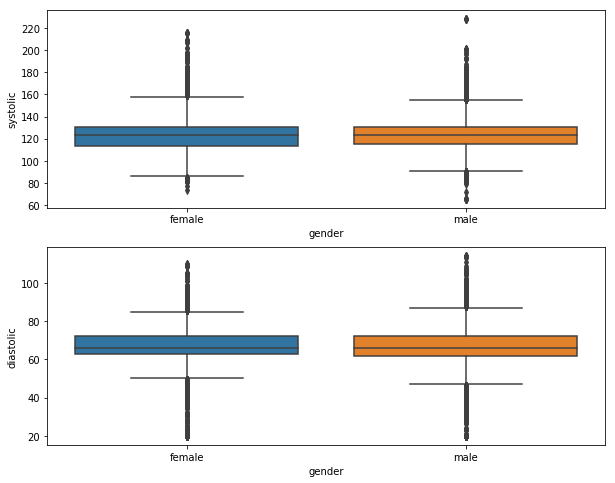

In [43]:
plot(['gender'], df)

Neither age nor gender appear to be a good indicator in this data set.
### BMI and Sodium Levels

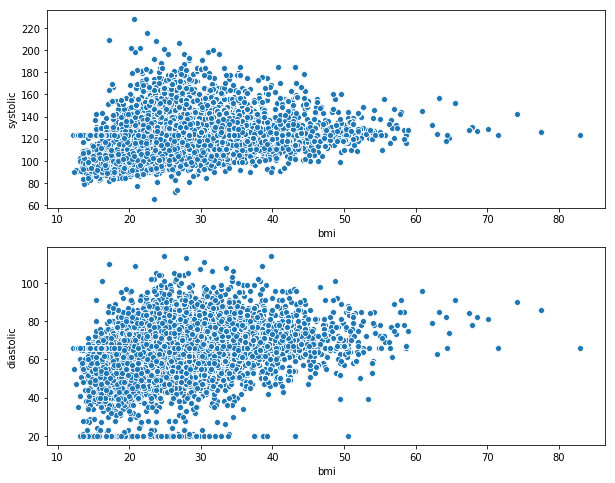

In [44]:
plot(['bmi'], df)

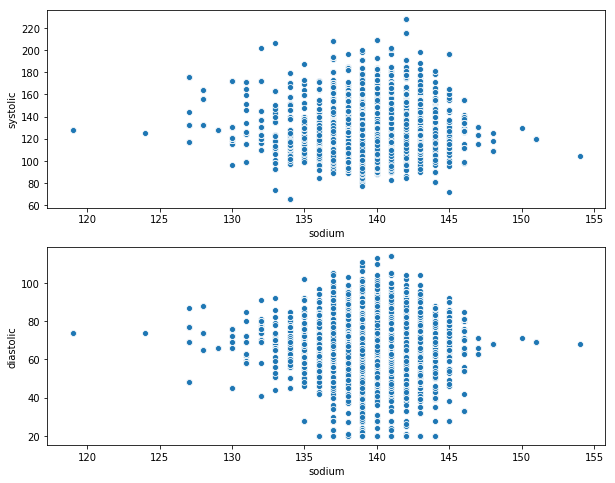

In [45]:
plot(['sodium'], df)

I'm surprised that sodium does not have a stronger corelation with blood pressure. We do see a slight correlation of bmi with systolic blood pressure, especially with the lower bmi measurements.
## Smoking

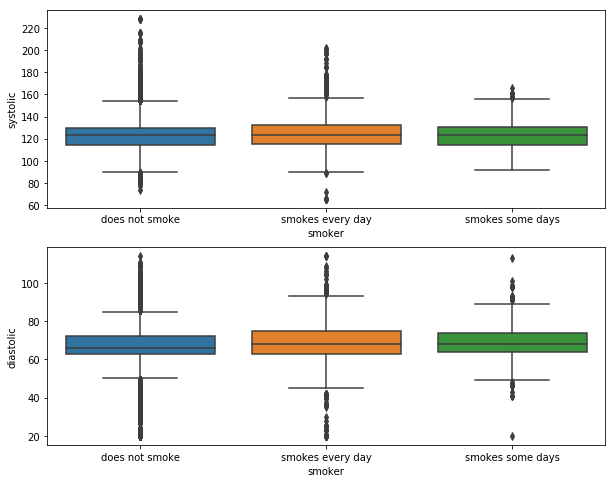

In [46]:
plot(['smoker'], df)

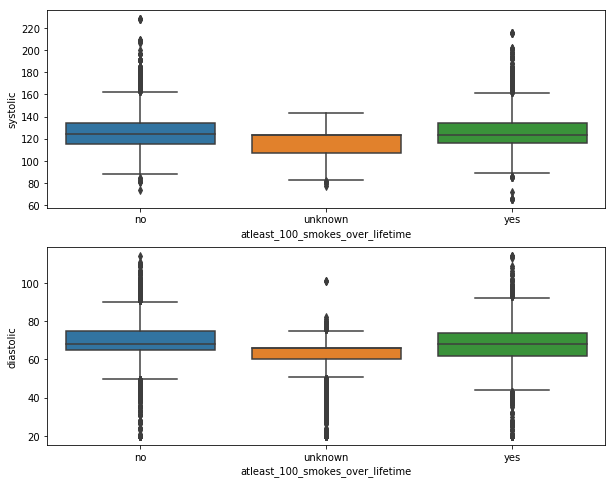

In [47]:
plot(['atleast_100_smokes_over_lifetime'], df)

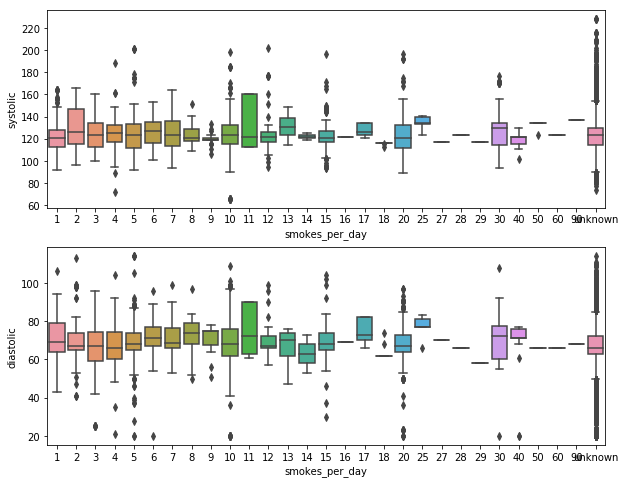

In [48]:
plot(['smokes_per_day'], df)

The smoking variables don't show much correlation with blood pressure either.
## Exercise

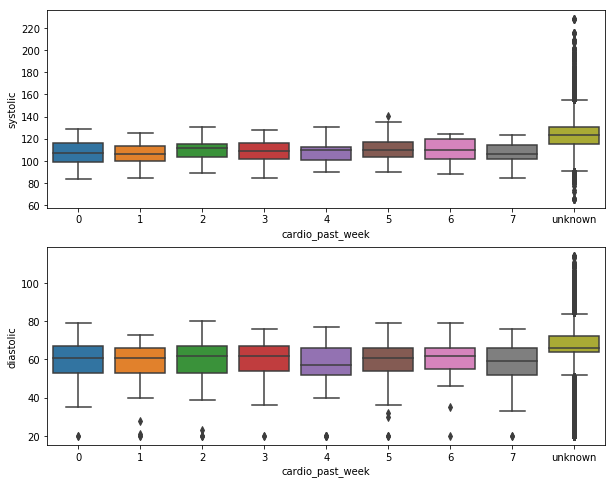

In [49]:
plot(['cardio_past_week'], df)

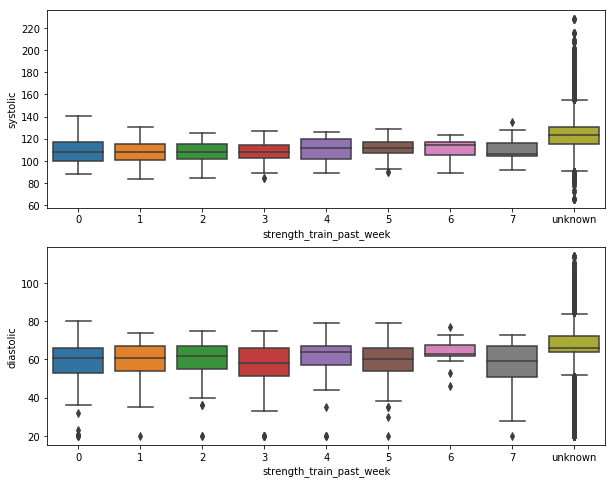

In [50]:
plot(['strength_train_past_week'], df)

Exercise, atleast within the last week, does not appear to be a good indicator either.
## Alcohol Consumption

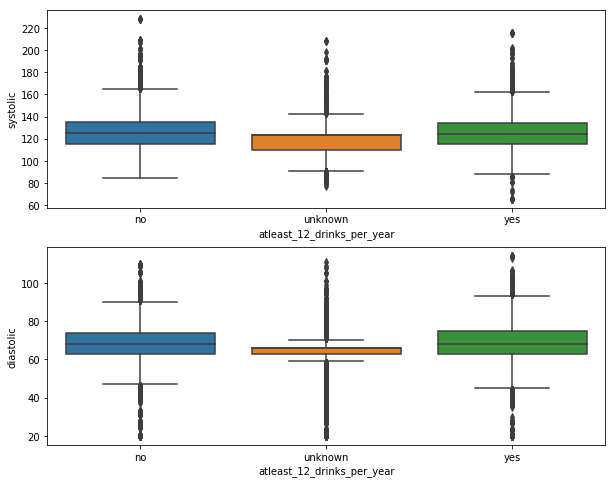

In [51]:
plot(['atleast_12_drinks_per_year'], df)

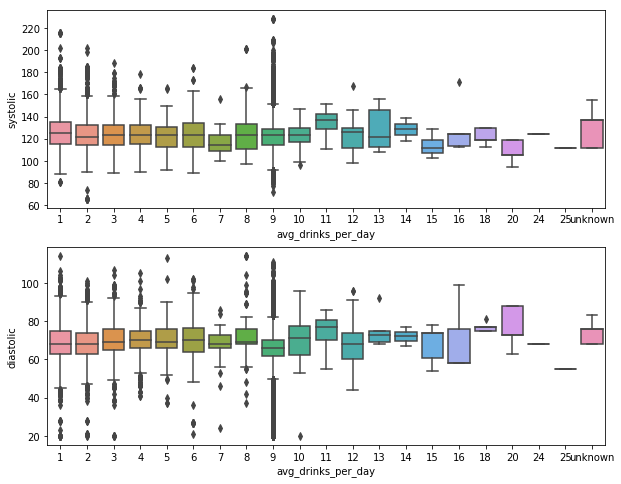

In [52]:
plot(['avg_drinks_per_day'], df)

There are many outliers in this set, however the alcohol fields don't seem to have any good indicators.
## Diabetes and Blood Pressure Medication

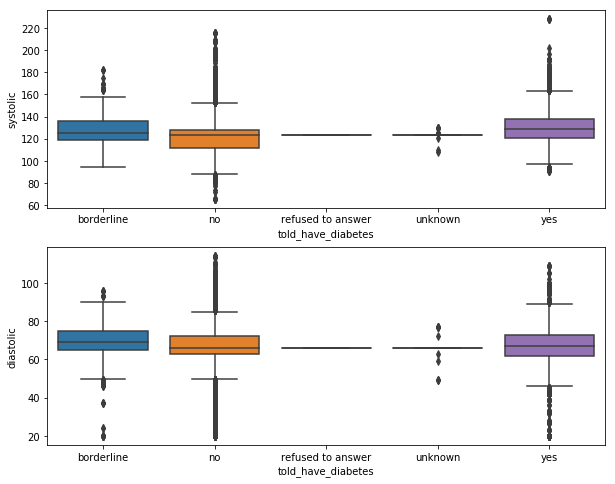

In [53]:
plot(['told_have_diabetes'], df)

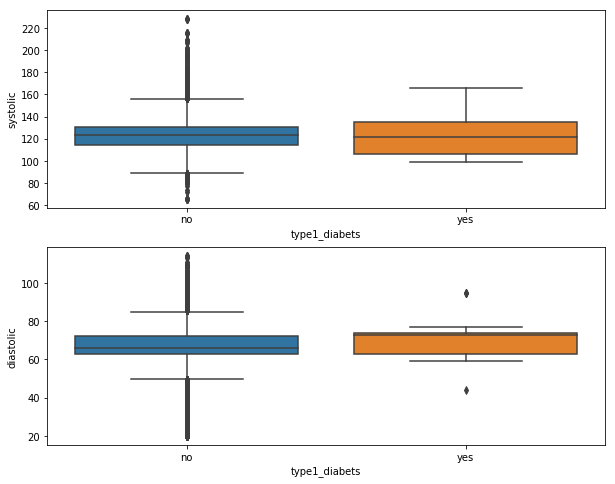

In [54]:
plot(['type1_diabets'], df)

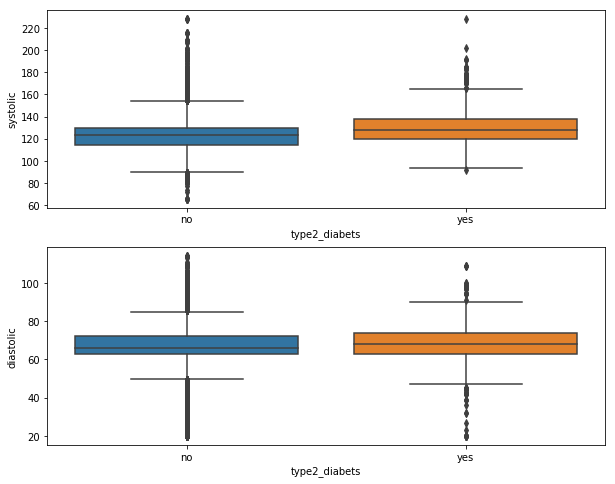

In [55]:
plot(['type2_diabets'], df)

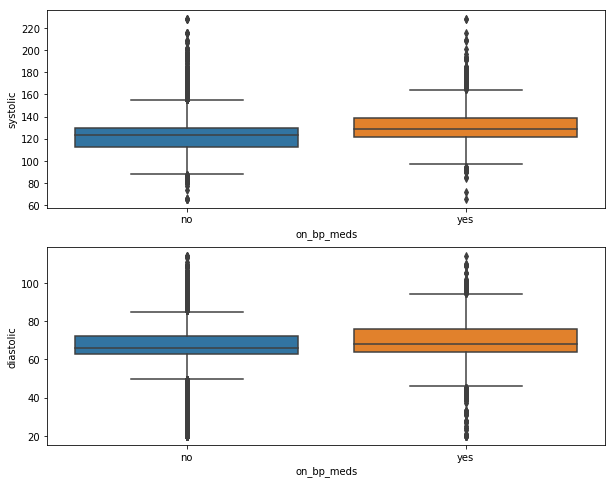

In [56]:
plot(['on_bp_meds'], df)

The medication fields don't seem to show good indications of blood pressure levels either. I'm not very confident that the given columns I've selected will prove very useful in a machine learning model, but lets find out!

## Building the Model
First we will create some helper methods to train models.

In [57]:
def split_numerical_categorical(df):
    """Splits a given DataFrame into numerical and categorical dataframes.
    
    Args: 
        df: DataFrame to split.
        
    Returns:
        Tuple of: (numerical DataFrame, categorical DataFrame)        
    """
    num_columns = []
    cat_columns = []
    for column in df.columns:
        if is_numerical(df[column]):
            num_columns.append(column)
        else:
            cat_columns.append(column)
    return (df[num_columns], df[cat_columns])
    
    
def creat_dummy_columns(df):
    """Creates a numpy array of dummy columns from the given DataFrame.
    
    Args: 
        df: DataFrame to create dummy columns from.
        
    Returns:
        numpy array of dummy columns.
    
    """
    x_train_cat = pd.get_dummies(df).astype('float64').values

def train_model(df, target_columns, regressor, multitask=False):
    """Trains a given regressor model with the given dataframe on the target columns.
    
    Args:
        df: DataFrame to get data from.
        target_columns: column names to train on.
        regressor: scikit-learn Regressor object to train.
        multitask: Boolean determining if we are using a multitask Regressor.
    
    Returns:
       Tuple of: trained Regressor model, root mean squared error of the model.
    
    """
    # Split the data
    df_train, df_test = train_test_split(df)
    df_train_num, df_train_cat = split_numerical_categorical(
        df_train.drop(columns=target_columns, axis=1))
    df_test_num, df_test_cat = split_numerical_categorical(
        df_test.drop(columns=target_columns, axis=1))
    
    # create numpy arrays
    x_train = df_train_num.values
    x_test = df_test_num.values
    y_train = df_train[target_columns].values
    y_test = df_test[target_columns].values
    
    # Scale the numerical data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # add categorical columns
    x_train_cat = pd.get_dummies(df_train_cat).astype('float64').values
    x_test_cat = pd.get_dummies(df_test_cat).astype('float64').values
    x_train = np.hstack([x_train, x_train_cat])
    x_test = np.hstack([x_test, x_test_cat])
    
    # train the model
    model = regressor if multitask else MultiOutputRegressor(regressor)
    model.fit(x_train, y_train)
    
    # test the model
    predicted_values = model.predict(x_test)
    mse = mean_squared_error(y_test, predicted_values)
    rmse = np.sqrt(mse)
    return [model, rmse]


### All Features
Now we will train and compare a linear regression model with a random forest regression model using all the features we've identified.

In [58]:
targets = ['systolic', 'diastolic']
lr_model, lr_rmse = train_model(df, targets, SGDRegressor(max_iter=1000))
mt_model, mt_rmse = train_model(df, targets, MultiTaskLasso(max_iter=1000), True)
rf_model, rf_rmse = train_model(df, targets, RandomForestRegressor())
print("Linear Regression RMSE: {}".format(lr_rmse))
print("MultiTask Lasso RMSE: {}".format(mt_rmse))
print("Random Forest Regression RMSE: {}".format(rf_rmse))

Linear Regression RMSE: 12.818562902141688
MultiTask Lasso RMSE: 13.091729125133963
Random Forest Regression RMSE: 7.941506013924504


### Greedy Model
We can see that the Random Forest Regressor is outperforming the Linear Regressor right now. Let's try to create new models using a greedy algorithm.

In [59]:
# First we will create some additional helper methods for creating our greedy model
def sort_columns_by_rmse(df, regressor, multitask=False):
    """Sorts a list of columns by their root mean squared error in descending order.
    
    Args:
        df: DataFrame to train with.
        regressor: model to train.
        
    Returns:
        a sorted list of column names
        
    """
    models = {}
    for column in df.drop(columns=['systolic', 'diastolic']):
        model, rmse = train_model(df, targets, regressor, multitask)
        models[column] = rmse
        print("{} RMSE:{}".format(column, rmse))
    return sorted(models, key=models.get)


def greedy_model(df, target_columns, sorted_columns, regressor, multitask=False):
    """Trains a given regressor model with the given dataframe on the target 
    columns using a greedy algorithm based on the sorted columns.
    
    Args:
        df: DataFrame to get data from.
        target_columns: column names to train on.
        sorted_columns: columns sorted by rmse to create greedy model with.
        regressor: scikit-learn Regressor object to train.
        multitask: Boolean determining if we are using a multitask Regressor.
    
    Returns:
       Tuple of: trained Regressor model, root mean squared error of the model.
    
    """
    greedy_columns = []
    greedy_columns_cat = []
    greedy_rmse = sys.maxsize
    greedy_predictions = None
    greedy_model = None
    for column in sorted_columns:
        temp_columns = greedy_columns + [column]
        print("training model with:", temp_columns)
        temp_model, temp_rmse = train_model(df, target_columns, regressor, multitask)
        print("Test model's RMSE:", temp_rmse)
        if temp_rmse < greedy_rmse:
            print("\nUpdating Greedy Model")
            greedy_columns = temp_columns
            greedy_rmse = temp_rmse
            greedy_model = temp_model
        print()
    print("Final Greedy Model Columns: ", greedy_columns)
    print("Final Greedy Model RMSE: ", greedy_rmse)
    return (greedy_model, greedy_rmse)

In [60]:
# Now we will create sorted lists for each model based on rmse
print("Linear Regression Columns:")
lr_columns = sort_columns_by_rmse(df, SGDRegressor(max_iter=1000))
print("\nMultiTask Lasso Columns:")
mt_columns = sort_columns_by_rmse(df, MultiTaskLasso(max_iter=1000), True)
print("\nRandom Forest Regression Columns:")
rf_columns = sort_columns_by_rmse(df, RandomForestRegressor())


Linear Regression Columns:
age RMSE:12.73229064864678
gender RMSE:13.165618752469761
sodium RMSE:13.11745224416906
smoker RMSE:13.08398928746524
atleast_100_smokes_over_lifetime RMSE:12.723746697171952
smokes_per_day RMSE:12.816453830533224
days_smoked_last_month RMSE:12.67561524131532
cardio_past_week RMSE:13.1458599446111
strength_train_past_week RMSE:12.933042462039237
atleast_12_drinks_per_year RMSE:12.836634898595657
avg_drinks_per_day RMSE:12.777540692837666
told_have_diabetes RMSE:12.835733212976542
bmi RMSE:12.977521619890927
type1_diabets RMSE:12.903279569427186
type2_diabets RMSE:12.885263350622655
on_bp_meds RMSE:12.888403663071992

MultiTask Lasso Columns:
age RMSE:13.020025035996046
gender RMSE:13.403084573105373
sodium RMSE:13.214262378804316
smoker RMSE:13.115448670278733
atleast_100_smokes_over_lifetime RMSE:13.27958777974895
smokes_per_day RMSE:13.293224960217168
days_smoked_last_month RMSE:13.193978716182727
cardio_past_week RMSE:13.22011189165456
strength_train_past

In [61]:
greedy_lr, greedy_lr_rmse = greedy_model(df, targets, lr_columns, 
                                         SGDRegressor(max_iter=1000))
greedy_mt, greedy_mt_rmse = greedy_model(df, targets, lr_columns, 
                                         MultiTaskLasso(max_iter=1000), True)
greedy_rf, greedy_rf_rmse = greedy_model(df, targets, rf_columns, 
                                         RandomForestRegressor())

training model with: ['days_smoked_last_month']
Test model's RMSE: 12.823369930566345

Updating Greedy Model

training model with: ['days_smoked_last_month', 'atleast_100_smokes_over_lifetime']
Test model's RMSE: 12.686337083089331

Updating Greedy Model

training model with: ['days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'age']
Test model's RMSE: 12.970272494262064

training model with: ['days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'avg_drinks_per_day']
Test model's RMSE: 13.173694564244744

training model with: ['days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'smokes_per_day']
Test model's RMSE: 12.95483625758121

training model with: ['days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'told_have_diabetes']
Test model's RMSE: 12.9271683700295

training model with: ['days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'atleast_12_drinks_per_year']
Test model's RMSE: 12.683729121806723

Updating Greedy Model

training m

In [62]:
print("Linear Regression Greedy Model RMSE: ", greedy_lr_rmse)
print("MultiTask Lasso Greedy Model RMSE: ", greedy_mt_rmse)
print("RandomForest Regression Greedy Model RMSE: ", greedy_rf_rmse)

Linear Regression Greedy Model RMSE:  12.683729121806723
MultiTask Lasso Greedy Model RMSE:  12.914600517906953
RandomForest Regression Greedy Model RMSE:  7.817840215136793


## Conclusion
With this run, the greedy linear regression model ended up with columns: 'days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'atleast_12_drinks_per_year' and an root mean squared error of around 12.7.


While the multitask lasso greedy model chose similar but more columns, performing a little worse: 'days_smoked_last_month', 'atleast_100_smokes_over_lifetime', 'on_bp_meds', 'sodium', rmse: 12.9.

The random forest regressor in the end performed the best with an rmse of 7.8 and selecting similar columns to the others: 'atleast_100_smokes_over_lifetime', 'strength_train_past_week', 'type2_diabets'

It's interesting that the 'atleast_100_smokes_over_lifetime' is the only consistent column among all 3 models. It seems to be the strongest predictor generally speaking in this particular subset of the original dataset, however a rmse of 7.8 is still not very good.


Overall the root mean squared error of even the best model is not adequate to predict a reasonable blood pressure reading. Some steps we can take in the future to improve these results include: 
1. revisiting the original feature documents to see if there is more useful data.
2. Perform unsupervised learning methods, such as k-means clustering, and Principal Component Analysis to identify predictive features.
3. Try alternative models, such as convolutional neural networks


In the end, even though the predictability of the models fell short, I learned a lot about feature engineering and exploration along the way. Such as how to deal with missing values in a variety of categories, often by deducing from other similar categories.